Available runs:
Run ID: xtj6u5oa, Name: baseline_10
Run ID: 7staqrp5, Name: baseline_9
Run ID: lsa9hodh, Name: baseline_8
Run ID: pexf35jx, Name: baseline_7
Run ID: 9bhwt26s, Name: baseline_6
Run ID: 81uzcoih, Name: baseline_5
Run ID: qsanspy0, Name: baseline_4
Run ID: n2y6mpql, Name: baseline_3
Run ID: q7m03fyg, Name: baseline_2
Run ID: 32d0fu3z, Name: baseline


NameError: name 'A' is not defined

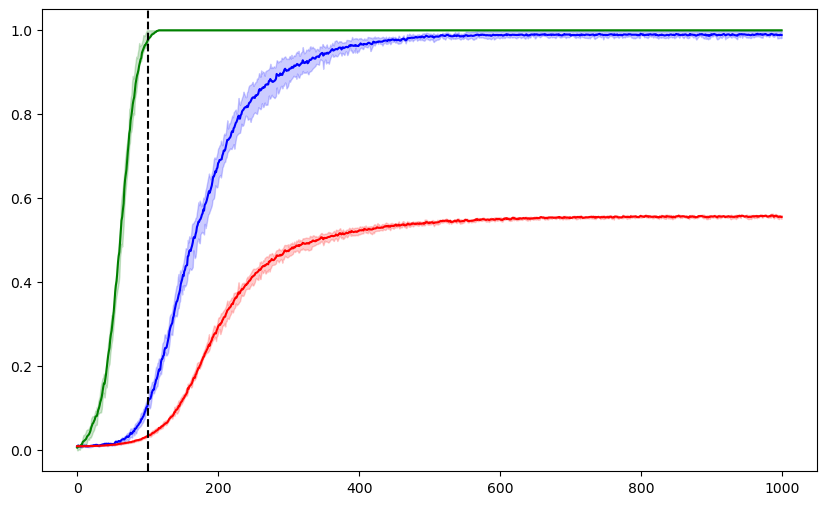

In [9]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Authenticate with WandB
wandb.login()

# Initialize the WandB API
api = wandb.Api()

# Specify the project and entity
entity = 'physicsofintelligence'  # Replace with your WandB username or team name
project = 'indexing-test'         # Replace with your WandB project name

# Fetch all runs in the project
runs = api.runs(f"{entity}/{project}")

# Print available runs to verify
print("Available runs:")
for run in runs:
    print(f"Run ID: {run.id}, Name: {run.name}")

# List of run IDs for runs starting with 'baseline'
run_ids = [run.id for run in runs if run.name == 'baseline' or run.name.startswith('baseline_')]

# Prepare lists to store the metrics
steps_list = []
train_accuracy_list = []
ov_eval_accuracy_list = []
correct_attention_list = []
train_loss_list = []
ov_eval_loss_list = []

# Fetch metrics from each run
for run_id in run_ids:
    try:
        run = api.run(f"{entity}/{project}/{run_id}")
        history = run.history(
            keys=['_step', 'train/accuracy', 'ov_eval/accuracy', 'train/correct_attention', 'train/loss', 'ov_eval/loss'],
            pandas=True
        )

        steps = history['_step'].values
        train_accuracy = history['train/accuracy'].values
        ov_eval_accuracy = history['ov_eval/accuracy'].values
        correct_attention = history['train/correct_attention'].values
        train_loss = history['train/loss'].values
        ov_eval_loss = history['ov_eval/loss'].values

        steps_list.append(steps)
        train_accuracy_list.append(train_accuracy)
        ov_eval_accuracy_list.append(ov_eval_accuracy)
        correct_attention_list.append(correct_attention)
        train_loss_list.append(train_loss)
        ov_eval_loss_list.append(ov_eval_loss)
    except wandb.errors.CommError as e:
        print(f"Run {run_id} not found or inaccessible. Error: {e}")

# Ensure that we have data
if not steps_list:
    print("No data found for the specified runs.")
    exit()

# Ensure all arrays are aligned by interpolating to a common step sequence
common_steps = np.unique(np.concatenate(steps_list))
train_accuracy_interp = []
ov_eval_accuracy_interp = []
correct_attention_interp = []
train_loss_interp = []
ov_eval_loss_interp = []

for steps, train_acc, ov_acc, attention, train_loss, ov_loss in zip(
    steps_list,
    train_accuracy_list,
    ov_eval_accuracy_list,
    correct_attention_list,
    train_loss_list,
    ov_eval_loss_list
):
    train_accuracy_interp.append(np.interp(common_steps, steps, train_acc))
    ov_eval_accuracy_interp.append(np.interp(common_steps, steps, ov_acc))
    correct_attention_interp.append(np.interp(common_steps, steps, attention))
    train_loss_interp.append(np.interp(common_steps, steps, train_loss))
    ov_eval_loss_interp.append(np.interp(common_steps, steps, ov_loss))

# Convert lists to NumPy arrays
train_accuracy_array = np.array(train_accuracy_interp)
ov_eval_accuracy_array = np.array(ov_eval_accuracy_interp)
correct_attention_array = np.array(correct_attention_interp)
train_loss_array = np.array(train_loss_interp)
ov_eval_loss_array = np.array(ov_eval_loss_interp)

# Compute mean and percentiles
def compute_stats(array):
    mean = np.nanmean(array, axis=0)
    percentile_25 = np.nanpercentile(array, 25, axis=0)
    percentile_75 = np.nanpercentile(array, 75, axis=0)
    return mean, percentile_25, percentile_75

train_acc_mean, train_acc_25, train_acc_75 = compute_stats(train_accuracy_array)
ov_acc_mean, ov_acc_25, ov_acc_75 = compute_stats(ov_eval_accuracy_array)
attention_mean, attention_25, attention_75 = compute_stats(correct_attention_array)
train_loss_mean, train_loss_25, train_loss_75 = compute_stats(train_loss_array)
ov_loss_mean, ov_loss_25, ov_loss_75 = compute_stats(ov_eval_loss_array)


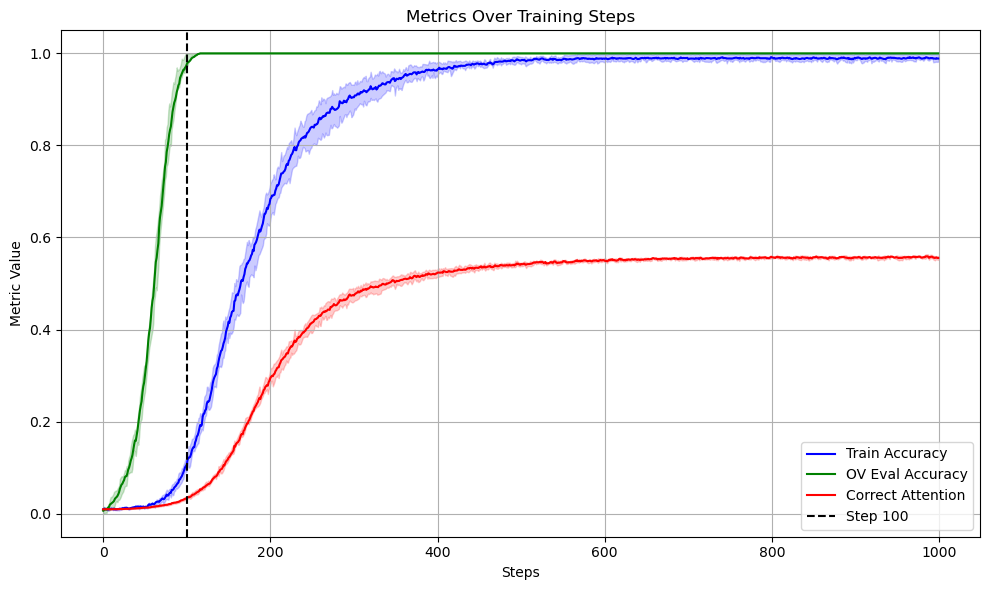

In [12]:
# Plotting
plt.figure(figsize=(10, 6))

# Plot the mean curves
plt.plot(common_steps, train_acc_mean, color='blue', label='Train Accuracy')
plt.plot(common_steps, ov_acc_mean, color='green', label='OV Eval Accuracy')
plt.plot(common_steps, attention_mean, color='red', label='Correct Attention')

# Fill between the 25th and 75th percentiles
plt.fill_between(common_steps, train_acc_25, train_acc_75, color='blue', alpha=0.2)
plt.fill_between(common_steps, ov_acc_25, ov_acc_75, color='green', alpha=0.2)
plt.fill_between(common_steps, attention_25, attention_75, color='red', alpha=0.2)

# Add vertical dashed line at step 100
plt.axvline(x=100, linestyle='--', color='black', label='Step 100')

plt.xlabel('Steps')
plt.ylabel('Metric Value')
plt.title('Metrics Over Training Steps')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

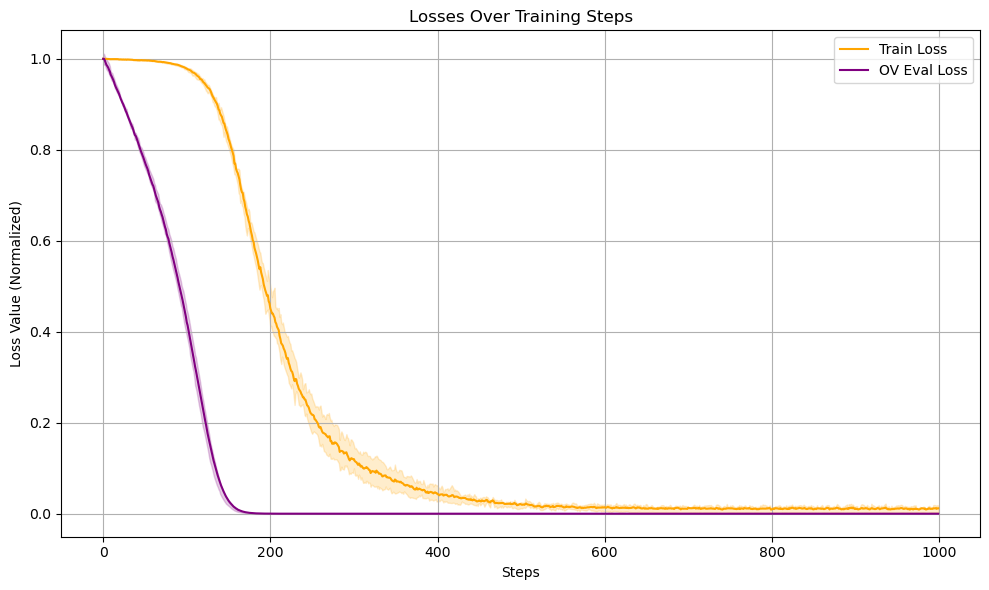

In [11]:

# Plotting Losses
plt.figure(figsize=(10, 6))

# Normalize losses to start at 1
train_loss_mean_norm = train_loss_mean / train_loss_mean[0]
ov_loss_mean_norm = ov_loss_mean / ov_loss_mean[0]
train_loss_25_norm = train_loss_25 / train_loss_mean[0]
train_loss_75_norm = train_loss_75 / train_loss_mean[0]
ov_loss_25_norm = ov_loss_25 / ov_loss_mean[0]
ov_loss_75_norm = ov_loss_75 / ov_loss_mean[0]

# Plot the mean curves
plt.plot(common_steps, train_loss_mean_norm, color='orange', label='Train Loss')
plt.plot(common_steps, ov_loss_mean_norm, color='purple', label='OV Eval Loss')

# Fill between the 25th and 75th percentiles
plt.fill_between(common_steps, train_loss_25_norm, train_loss_75_norm, color='orange', alpha=0.2)
plt.fill_between(common_steps, ov_loss_25_norm, ov_loss_75_norm, color='purple', alpha=0.2)

plt.xlabel('Steps')
plt.ylabel('Loss Value (Normalized)')
plt.title('Losses Over Training Steps')
plt.legend()
plt.grid(True)
plt.tight_layout()  
plt.show()

